## Interactive lammps

In [2]:
from lammps import PyLammps

In [3]:
L = PyLammps()

LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
LAMMPS output is captured by PyLammps wrapper


In [4]:
L.command("units lj")
L.command("atom_style full")
L.command("bond_style harmonic")
L.command("pair_style lj/expand 1.12246")
L.command("dimension 3")
L.command("boundary p p p")
L.command("neighbor 0.8 bin")

In [5]:
L.command('read_data start/startBullet.data')

Reading data file ...
  orthogonal box = (-10.4854 -10.4854 -2.66972) to (10.4854 10.4854 2.4435)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  1944 atoms
  reading velocities ...
  1944 velocities
  scanning bonds ...
  2 = max bonds/atom
  reading bonds ...
  1920 bonds
Finding 1-2 1-3 1-4 neighbors ...
  special bond factors lj:   0          0          0         
  special bond factors coul: 0          0          0         
  8 = max # of 1-2 neighbors
  8 = max # of 1-3 neighbors
  16 = max # of 1-4 neighbors
  24 = max # of special neighbors
  special bonds CPU = 0.00142312 secs
  read_data CPU = 0.014924 secs


In [6]:
L.command('change_box all boundary p p f')

Changing box ...


In [7]:
L.command('change_box all z delta -40.0 20.0 units box')

Changing box ...
  orthogonal box = (-10.4854 -10.4854 -42.6697) to (10.4854 10.4854 22.4435)


#### Potentials 

In [8]:
L.command('bond_style    harmonic')
L.command('bond_coeff    1 2500.0 0.9')
L.command('bond_coeff    2 2500.0 0.9')

In [9]:
L.command('special_bonds fene')

Finding 1-2 1-3 1-4 neighbors ...
  special bond factors lj:   0          1          1         
  special bond factors coul: 0          1          1         
  8 = max # of 1-2 neighbors
  24 = max # of special neighbors
  special bonds CPU = 0.00126004 secs


In [10]:
L.command('pair_style lj/expand 1.12246')
L.command('pair_coeff    1 1 1.0 1.0  0.0   2.5')
L.command('pair_coeff    1 2 1.0 1.0  0.0   2.5')
L.command('pair_coeff    2 2 1.0 1.0  0.0   2.5')
L.command('pair_coeff    1 3 1.0 1.0  0.0   2.5') #bullet-core interaction
L.command('pair_coeff    2 3 1.0 1.0  0.0   2.5') #bullet-polymer interaction
L.command('pair_coeff    3 3 1.0 1.0  0.0   2.5') #bullet-bullet, not relevant

#### Variables Definition

In [11]:
L.command('variable size equal yhi')
L.command('variable lBox equal ${size}')
L.command('variable dt equal 0.005')
L.command('variable massBullet equal 1.0')
L.command('variable velocityBullet equal -2')
L.command('variable radiusBullet equal 5')

#### Thermo Style

In [12]:
L.command('thermo  50')
L.command('compute stressA all stress/atom NULL')
L.command('compute p all reduce sum c_stressA[1] c_stressA[2] c_stressA[3]')
L.command('variable        pz equal -(c_p[3])/(vol)')
L.command('variable        pxy equal -(c_p[1]+c_p[2])/(2*vol)')
L.command('thermo_style    custom step temp ebond epair ke etotal enthalpy vol density press v_pxy v_pz')

#### Fix Borders

In [13]:
L.command('replicate 2 2 1')

Replicating atoms ...
  orthogonal box = (-10.4854 -10.4854 -42.6697) to (31.4561 31.4561 22.4435)
  1 by 1 by 1 MPI processor grid
  7776 atoms
  7680 bonds
Finding 1-2 1-3 1-4 neighbors ...
  special bond factors lj:   0          1          1         
  special bond factors coul: 0          1          1         
  8 = max # of 1-2 neighbors
  8 = max # of special neighbors
  special bonds CPU = 0.00268197 secs
  replicate CPU = 0.00776887 secs


In [14]:
L.command('region hole cylinder z ${lBox} ${lBox} 20 -10.0 10.0 side in units box')

In [15]:
L.command('group hole region hole')

5578 atoms in group hole


In [16]:
L.command('group film type 1 2')

7776 atoms in group film


In [17]:
L.command('group base subtract film hole')

2198 atoms in group base


In [18]:
L.command('fix nailed base setforce 0.0 0.0 0.0')
L.command('velocity base set 0.0 0.0 0.0 units box')
L.command('velocity hole create 0.1 12394123')

#### Equilibrate

In [19]:
L.command('fix nvt0 all nvt temp 0.1 0.1 0.5')

In [20]:
L.command('reset_timestep 0')
L.command('unfix nvt0')

#### Create Gold Bullet

In [21]:
L.command('lattice diamond 7.2')

Lattice spacing in x,y,z = 1.03574 1.03574 1.03574


In [22]:
L.command('variable hBullet equal 5+${radiusBullet}')
L.command('region 1 sphere ${lBox} ${lBox} ${hBullet} ${radiusBullet} side in units box')

In [23]:
L.command('create_atoms 3 region 1 units box')

Created 3741 atoms
  create_atoms CPU = 0.00326085 secs


In [24]:
L.command('group indent type 3')

3741 atoms in group indent


In [25]:
L.command('mass 3 ${massBullet}')
L.command('neigh_modify exclude group indent indent')

In [26]:
L.command('fix 1 indent rigid single')

1 rigid bodies with 3741 atoms


In [27]:
L.command('velocity indent set 0.0 0.0 ${velocityBullet} units box')

#### Shoot

In [28]:
L.command('fix nve1 hole nve')
L.command('compute 1 indent com')
L.command('compute 2 all ke')
L.command('compute 3 all pe')
L.command('compute 4 indent ke')
L.command('compute 5 indent group/group film')
L.command('fix kin all ave/time 1 1 10 c_4 file kinetic.data')
L.command('dump mydump all custom 200 lmp_data/Conf_*.dat id type xu yu zu c_stressA[1] c_stressA[2] c_stressA[3]')
L.command('dump_modify mydump sort id')

In [29]:
L.run(8000)

['Neighbor list info ...',
 '  update every 1 steps, delay 10 steps, check yes',
 '  max neighbors/atom: 2000, page size: 100000',
 '  master list distance cutoff = 3.3',
 '  ghost atom cutoff = 3.3',
 '  binsize = 1.65, bins = 26 26 40',
 '  2 neighbor lists, perpetual/occasional/extra = 1 1 0',
 '  (1) pair lj/expand, perpetual',
 '      attributes: half, newton on',
 '      pair build: half/bin/newton',
 '      stencil: half/bin/3d/newton',
 '      bin: standard',
 '  (2) compute group/group, occasional, copy from (1)',
 '      attributes: half, newton on',
 '      pair build: copy',
 '      stencil: none',
 '      bin: none',
 'Setting up Verlet run ...',
 '  Unit style    : lj',
 '  Current step  : 0',
 '  Time step     : 0.005',
 'Per MPI rank memory allocation (min/avg/max) = 15.05 | 15.05 | 15.05 Mbytes',
 'Step Temp E_bond E_pair KinEng TotEng Enthalpy Volume Density Press v_pxy v_pz ',
 '       0   0.71308988  0.030745527   -3.9300748   0.72228445   -3.1770448   -2.8117006   

### Visualisation

In [30]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
import nglview as nv
import MDAnalysis as mda

u = mda.Universe('lmp_data/Conf.dat',format='LAMMPSDUMP')

In [31]:
atoms = u.atoms

In [32]:
view = nv.show_mdanalysis(atoms)

In [33]:
view

NGLWidget(max_frame=40)

In [34]:
import numpy as np
kin = np.loadtxt('kinetic.data')

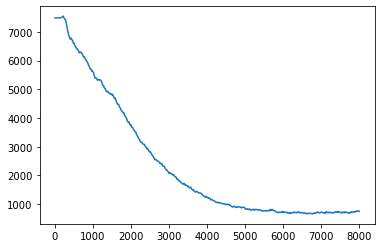

In [35]:
import matplotlib.pyplot as plt

plt.plot(kin[:,0],kin[:,1])

In [46]:
%load_ext watermark

%watermark -v -m -p numpy,matplotlib,nglview,MDAnalysis,lammps

print(" ")
%watermark -u -n -t -z

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.31.1

numpy     : 1.20.3
matplotlib: 3.5.1
nglview   : 3.0.3
MDAnalysis: 2.0.0
lammps    : 3Mar2020

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.4.151-1.el7.elrepo.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

 
Last updated: Mon Feb 14 2022 11:16:58CET

